In [2]:
import time
import datetime
 
import matplotlib
import matplotlib.pyplot as plt
 
import tensorflow as tf
import numpy as np

import os
import glob
import pandas as pd
import xarray as xr

# Helper Function

In [3]:
class Timer():
    """
    A small class to measure time during training.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        
        return elapsed_time
    
def eval_metrics(metrics, metric_lists):
    for i, m in enumerate(metrics):
        val = m.result()
        metric_lists[i].append(val)
        m.reset_states()
        
def plot_AE_representation(img_original, img_reconstructed):
    fig, ax = plt.subplots(1,4, figsize=(10,15))
    
    ax[0].imshow(img_original[0,:,:,0], cmap='gray', origin='lower')
    ax[1].imshow(img_reconstructed[0,:,:,0], cmap='gray', origin='lower')
    
    ax[2].imshow(img_original[0,:,:,1], cmap='gray', origin='lower')
    ax[3].imshow(img_reconstructed[0,:,:,1], cmap='gray', origin='lower')
    
    plt.tight_layout()
    plt.show()  
    
def test_AE():
    input_shape = (4, 36, 72, 2)
    data = tf.random.normal(input_shape)
    print(input_shape)

    model_AE = CNN_Autoencoder(input_dim=(None, 36, 72, 2), 
                               latent_dim=1000,
                               restore_shape=(9, 18, 64))

    latent = model_AE.encoder(data)
    x = model_AE.decoder(latent)

# Data generator

In [4]:
data_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
day_len = 1 
dmodel = 'IPSL-CM6A-LR' 

# load all data externally to save computationtime
temp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(dmodel)).tas)
prec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(dmodel)).pr)
npp_files = glob.glob('data/net_primary_production_on_land/historical/**/*.nc', recursive=True) 
npp_ds = np.array(xr.open_mfdataset(np.random.choice(np.array(npp_files))).npp)
lai_ds = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(dmodel))
lai_ds['lai'] = lai_ds.lai.fillna(0)
npp_ds = np.nan_to_num(npp_ds)

# Normalize inputs
temp_ds = (temp_ds - np.mean(temp_ds)) / np.std(temp_ds)
prec_ds = (prec_ds - np.mean(prec_ds)) / np.std(prec_ds)

# MinMax outputs
mini = 0
maxi = 10
npp_ds = mini+(((npp_ds-np.min(npp_ds))*(maxi-mini))/((np.max(npp_ds)-np.min(npp_ds))))
lai_ds['lai'] = mini+(((lai_ds['lai']-np.min(lai_ds['lai']))*(maxi-mini))/((np.max(lai_ds['lai'])-np.min(lai_ds['lai']))))

max_month = 1978
min_month = day_len//28

def gen_data_card():
    while True:
        dataset = np.random.randint(0, 1)
        output_month_i = np.random.randint(min_month, max_month)  # y_pred timepoint in int
                   
        try:
            endstamp = lai_ds.indexes['time'].to_datetimeindex()[output_month_i]  # cfttimeindex to datetime
        except:
            endstamp = lai_ds.indexes['time'][output_month_i]
            
        output_day_i = (endstamp - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int
        
        if dataset == 0:
            # continue with month-based metrics
            lai = lai_ds.lai[output_month_i]
            npp = npp_ds[output_month_i]
            outputs = np.stack((lai, npp), axis=-1)
        else:
            # day-based metrics
            temp = temp_ds[output_day_i-day_len:output_day_i][0]
            prec = prec_ds[output_day_i-day_len:output_day_i][0]
            outputs = np.stack((temp, prec), axis=-1)  # two features
        
        yield outputs

In [5]:
batch_size = 16

ds = tf.data.Dataset.from_generator(gen_data_card,
                                    output_types = (tf.float32))

train_ds = ds.batch(batch_size).take(50).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = ds.batch(batch_size).take(10).prefetch(tf.data.experimental.AUTOTUNE)

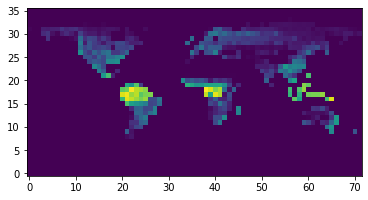

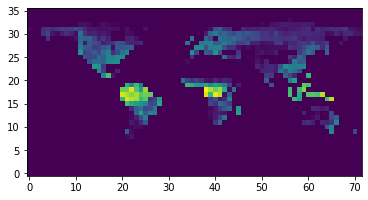

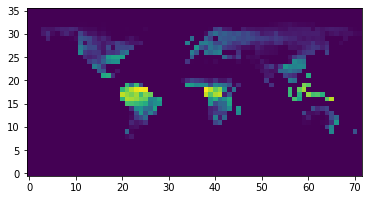

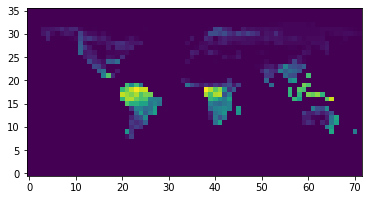

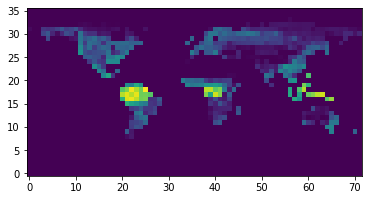

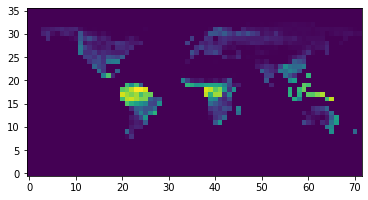

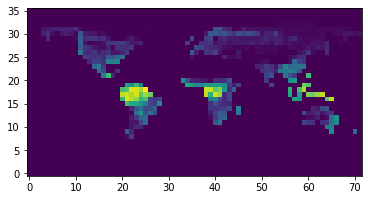

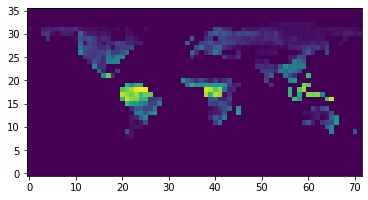

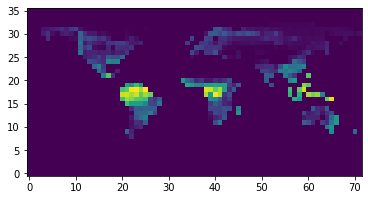

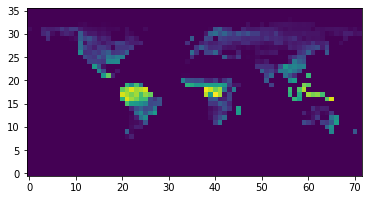

In [40]:
for i in val_ds.take(2):
    plt.imshow(i[0,:,:,0], origin='lower')
    plt.show()

# Autoencoder

In [6]:
class CNN_Encoder(tf.keras.layers.Layer):
    def __init__(self, input_dim, latent_dim):
        super(CNN_Encoder, self).__init__()
        
        self.layers = []
        
        self.layers.append(tf.keras.layers.Conv2D(filters=32,
                                                  kernel_size=3,
                                                  strides=2,
                                                  padding='same',
                                                  input_shape=input_dim))  
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))

        self.layers.append(tf.keras.layers.Conv2D(filters=64,
                                                  kernel_size=3,
                                                  strides=2,
                                                  padding='same'))  
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))

        self.layers.append(tf.keras.layers.Flatten())
        self.layers.append(tf.keras.layers.Dense(latent_dim, activation='relu'))
        
    def call(self, x, training=False):
        for layer in self.layers:
            try: 
                x = layer(x, training) 
            except:
                x = layer(x)
        return x
    
    def make_untrainable():
        for layer in self.layers:
            layer.trainable = False

class CNN_Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, output_dim, restore_shape):
        super(CNN_Decoder, self).__init__()
        self.layers = []
        self.layers.append(tf.keras.layers.Dense(units=int(tf.math.reduce_prod((restore_shape))),
                                                 input_shape=(latent_dim,)))
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))
        
        self.layers.append(tf.keras.layers.Reshape(target_shape=restore_shape))        
        self.layers.append(tf.keras.layers.Conv2DTranspose(filters=32,
                                                           kernel_size=3,
                                                           strides=2,
                                                           padding='same'))
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))
       
        self.layers.append(tf.keras.layers.Conv2DTranspose(filters=2,
                                                  kernel_size=3,
                                                  strides=2,
                                                  padding='same'))  
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('sigmoid'))
       
    def call(self, x, training=False):
        for layer in self.layers:
            try:
                x = layer(x, training) 
            except:
                x = layer(x)
        return x
    
    def make_untrainable():
        for layer in self.layers:
            layer.trainable = False
        
class CNN_Autoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim, restore_shape):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = CNN_Encoder(input_dim=input_dim,
                                   latent_dim=latent_dim)
        
        self.decoder = CNN_Decoder(latent_dim=latent_dim,
                                   output_dim=input_dim,
                                   restore_shape=restore_shape)
        
    def call(self, x, training=False):
        x = tf.ensure_shape(x, (batch_size, 36, 72, 2))
        x = self.encoder(x, training)
        x = self.decoder(x, training)
        
        return x
    
    def make_untrainable():
        self.trainable = False
        self.encoder.make_untrainable()
        self.decoder.make_untrainable()

# Training the Autoencoder

In [7]:
@tf.function
def train_step_AE(model, train_ds, loss_function, optimizer, train_loss_metric):
    '''
    Training for one epoch. Adjusted for Autoencoder as there are no acc_metric.
    '''
    for img in train_ds:
        with tf.GradientTape() as tape:
            # forward pass
            prediction = model(img, training=True)
            loss = loss_function(img, prediction) 

        # backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)

@tf.function
def eval_step_AE(model, ds, loss_function, loss_metric):
    '''
    Evaluate without training. Adjusted for autoencoder. 
    Return a random image and reconstructed version of it.
    '''
    prediction = 0.0
    img = 0.0

    for img in ds:
        # forward pass
        prediction = model(img, training=False)
        
        # update metrics
        loss = loss_function(img, prediction)
        loss_metric.update_state(loss)
        
    return img, prediction

In [8]:
# Hyperparameter
epochs = 25
laerning_rate = 0.001

tf.keras.backend.clear_session()
timer = Timer()

model_AE = CNN_Autoencoder(input_dim=(None, 36, 72, 2), 
                           latent_dim=5000,
                           restore_shape=(9, 18, 64))

loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(laerning_rate)

metrics_AE = [tf.keras.metrics.Mean('train_loss'),
              tf.keras.metrics.Mean('val_loss')]


losses_AE = [[],[]] # loss[0] - train, loss[1] - test

times = []

[INFO] - Started training the cnn__autoencoder model.

[EPOCH] ____________________0____________________
[0] - Finished Epoch in 41.56 seconds - train_loss: 1.5866; val_loss: 1.7090

[INFO] - Total time elapsed: 0.6926 min. Total time remaining: 16.6226 min.


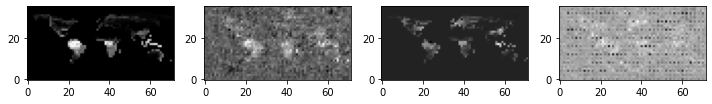


[EPOCH] ____________________1____________________
[1] - Finished Epoch in 40.04 seconds - train_loss: 1.4975; val_loss: 1.6763

[EPOCH] ____________________2____________________
[2] - Finished Epoch in 40.29 seconds - train_loss: 1.4844; val_loss: 1.6167

[INFO] - Total time elapsed: 2.0315 min. Total time remaining: 14.8974 min.


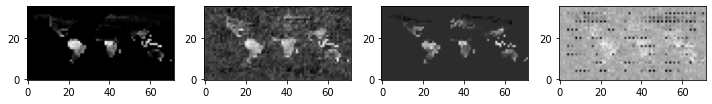


[EPOCH] ____________________3____________________
[3] - Finished Epoch in 40.13 seconds - train_loss: 1.4486; val_loss: 1.5303

[EPOCH] ____________________4____________________
[4] - Finished Epoch in 40.15 seconds - train_loss: 1.4312; val_loss: 1.4686

[INFO] - Total time elapsed: 3.3695 min. Total time remaining: 13.4780 min.


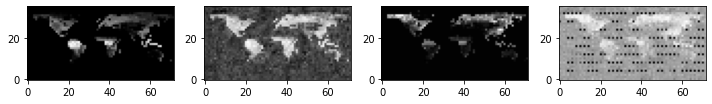


[EPOCH] ____________________5____________________
[5] - Finished Epoch in 40.35 seconds - train_loss: 1.4180; val_loss: 1.4440

[EPOCH] ____________________6____________________
[6] - Finished Epoch in 40.40 seconds - train_loss: 1.3828; val_loss: 1.3969

[INFO] - Total time elapsed: 4.7153 min. Total time remaining: 12.1251 min.


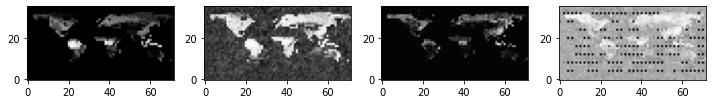


[EPOCH] ____________________7____________________
[7] - Finished Epoch in 40.64 seconds - train_loss: 1.3631; val_loss: 1.3762

[EPOCH] ____________________8____________________
[8] - Finished Epoch in 40.21 seconds - train_loss: 1.3527; val_loss: 1.3657

[INFO] - Total time elapsed: 6.0628 min. Total time remaining: 10.7784 min.


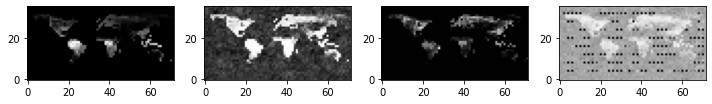


[EPOCH] ____________________9____________________
[9] - Finished Epoch in 40.00 seconds - train_loss: 1.3581; val_loss: 1.3502

[EPOCH] ____________________10____________________
[10] - Finished Epoch in 39.94 seconds - train_loss: 1.3397; val_loss: 1.2939

[INFO] - Total time elapsed: 7.3951 min. Total time remaining: 9.4119 min.


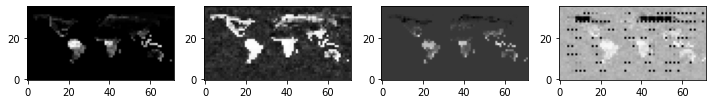


[EPOCH] ____________________11____________________
[11] - Finished Epoch in 40.08 seconds - train_loss: 1.3094; val_loss: 1.3264

[EPOCH] ____________________12____________________
[12] - Finished Epoch in 40.41 seconds - train_loss: 1.3199; val_loss: 1.2749

[INFO] - Total time elapsed: 8.7366 min. Total time remaining: 8.0646 min.


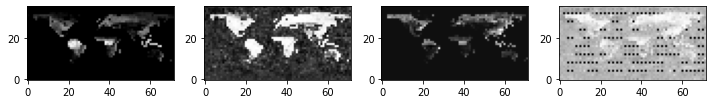


[EPOCH] ____________________13____________________
[13] - Finished Epoch in 41.09 seconds - train_loss: 1.2893; val_loss: 1.2844

[EPOCH] ____________________14____________________
[14] - Finished Epoch in 40.06 seconds - train_loss: 1.2843; val_loss: 1.2868

[INFO] - Total time elapsed: 10.0891 min. Total time remaining: 6.7261 min.


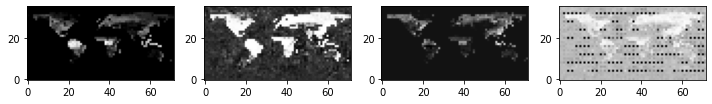


[EPOCH] ____________________15____________________
[15] - Finished Epoch in 39.96 seconds - train_loss: 1.2726; val_loss: 1.2938

[EPOCH] ____________________16____________________
[16] - Finished Epoch in 40.17 seconds - train_loss: 1.2608; val_loss: 1.2724

[INFO] - Total time elapsed: 11.4246 min. Total time remaining: 5.3763 min.


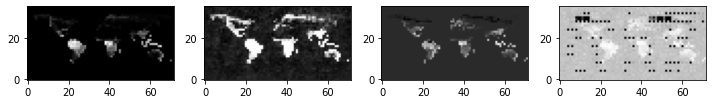


[EPOCH] ____________________17____________________
[17] - Finished Epoch in 39.81 seconds - train_loss: 1.2470; val_loss: 1.2389

[EPOCH] ____________________18____________________
[18] - Finished Epoch in 39.65 seconds - train_loss: 1.2361; val_loss: 1.2846

[INFO] - Total time elapsed: 12.7490 min. Total time remaining: 4.0260 min.


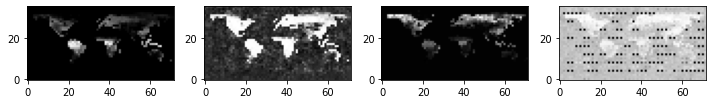


[EPOCH] ____________________19____________________
[19] - Finished Epoch in 39.71 seconds - train_loss: 1.2317; val_loss: 1.2601

[EPOCH] ____________________20____________________
[20] - Finished Epoch in 39.75 seconds - train_loss: 1.2233; val_loss: 1.2450

[INFO] - Total time elapsed: 14.0733 min. Total time remaining: 2.6806 min.


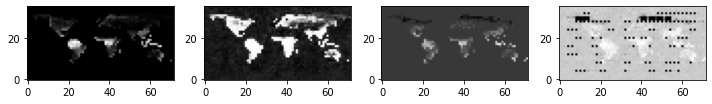


[EPOCH] ____________________21____________________
[21] - Finished Epoch in 40.11 seconds - train_loss: 1.2257; val_loss: 1.2218

[EPOCH] ____________________22____________________
[22] - Finished Epoch in 39.76 seconds - train_loss: 1.2397; val_loss: 1.1880

[INFO] - Total time elapsed: 15.4045 min. Total time remaining: 1.3395 min.


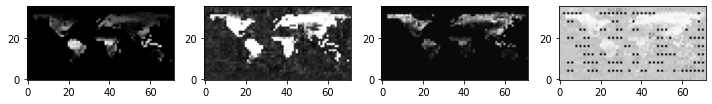


[EPOCH] ____________________23____________________
[23] - Finished Epoch in 39.96 seconds - train_loss: 1.2029; val_loss: 1.2331

[EPOCH] ____________________24____________________
[24] - Finished Epoch in 40.21 seconds - train_loss: 1.2133; val_loss: 1.1655

[INFO] - Total time elapsed: 16.7408 min. Total time remaining: 0.0000 min.


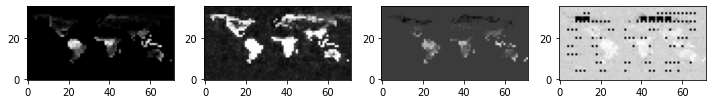


[INFO] - Total run time: 16.7408 min.


In [9]:
print(f'[INFO] - Started training the {model_AE.name} model.')

for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    timer.start()
    
    # Training step    
    train_step_AE(model_AE, train_ds, loss_function, optimizer, metrics_AE[0])
    
    # Test step    
    img_original, img_reconstructed = eval_step_AE(model_AE, val_ds, loss_function, metrics_AE[1])
    
    # Evaluate the metrics
    eval_metrics(metrics=metrics_AE, metric_lists=losses_AE)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)

    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {losses_AE[0][-1]:0.4f}; val_loss: {losses_AE[1][-1]:0.4f}')
    
    # print progress every while
    if epoch%2 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')
        plot_AE_representation(img_original, img_reconstructed)

                    
print(f'\n[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

# LSTM Model

In [13]:
data_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
day_len = 30 
dmodel = 'IPSL-CM6A-LR'

# load all data externally to save computationtime
temp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(dmodel)).tas)
prec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(dmodel)).pr)
npp_files = glob.glob('data/net_primary_production_on_land/historical/**/*.nc', recursive=True) 
npp_ds = np.array(xr.open_mfdataset(np.random.choice(np.array(npp_files))).npp)
lai_ds = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(dmodel))
lai_ds['lai'] = lai_ds.lai.fillna(0)
npp_ds = np.nan_to_num(npp_ds)

# Normalize inputs
temp_ds = (temp_ds - np.mean(temp_ds)) / np.std(temp_ds)
prec_ds = (prec_ds - np.mean(prec_ds)) / np.std(prec_ds)

# MinMax outputs
mini = 0
maxi = 10
npp_ds = mini+(((npp_ds-np.min(npp_ds))*(maxi-mini))/((np.max(npp_ds)-np.min(npp_ds))))
lai_ds['lai'] = mini+(((lai_ds['lai']-np.min(lai_ds['lai']))*(maxi-mini))/((np.max(lai_ds['lai'])-np.min(lai_ds['lai']))))

max_month = 1978
min_month = day_len//28

def gen_data_card():
    while True:
        
        output_month_i = np.random.randint(min_month, max_month)  # y_pred timepoint in int
        
        try:
            endstamp = lai_ds.indexes['time'].to_datetimeindex()[output_month_i]  # cfttimeindex to datetime
        except:
            endstamp = lai_ds.indexes['time'][output_month_i]
            
        output_day_i = (endstamp - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int

        # continue with month-based metrics
        lai = lai_ds.lai[output_month_i]
        npp = npp_ds[output_month_i]

        # day-based metrics
        temp = temp_ds[output_day_i-day_len:output_day_i]
        prec = prec_ds[output_day_i-day_len:output_day_i]

        inputs = np.stack((temp,prec), axis=-1)  # two features
        outputs = np.stack((lai,npp), axis=-1)
        
        yield (inputs, outputs)

In [14]:
BATCH_SIZE = 16

ds = tf.data.Dataset.from_generator(gen_data_card,output_types = (tf.float32,tf.float32))

train_ds = ds.batch(BATCH_SIZE).take(30).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = ds.batch(BATCH_SIZE).take(30).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
for x, y in ds.take(2):
    print(x.shape, y.shape)

(1, 36, 72, 2) (36, 72, 2)
(1, 36, 72, 2) (36, 72, 2)


In [51]:
class RNN(tf.keras.Model):
    def __init__(self, rnn_units, autoencoder):
        super().__init__(GRU_AE, self)
        self.autoencoder = autoencoder
        self.autoencoder.make_untrainable()      
        
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True)
        
    def call(self, x, training=False):
        x = self.autoencoder.encode(x)
        x = self.gru(x, training=training)
        x = self.autoencoder.decode(x)

        return x

In [ ]:
# Hyperparameter
epochs = 25
learning_rate = 0.001

tf.keras.backend.clear_session()
timer = Timer()

model_RNN = RNN(40, model_AE)

loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
metrics_RNN = [tf.keras.metrics.Mean('train_loss'),
              tf.keras.metrics.Mean('test_loss')]

# loss[0] - train, loss[1] - test
losses_RNN = []

times = []

In [ ]:
@tf.function
def train_step_RNN(model, train_ds, loss_function, optimizer, train_loss_metric):
    '''
    Training for one epoch. Adjusted for Autoencoder as there are no acc_metric.
    '''
    for x, label in train_ds:  # there are no (input,label) pairs
        with tf.GradientTape() as tape:
            # forward pass
            prediction = model(x, training=True)
            loss = loss_function(x, prediction) 

        # backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)

# @tf.function
# def eval_step_RNN(model, ds, loss_function, loss_metric):
#     '''
#     Evaluate without training. Adjusted for autoencoder. 
#     Return a random image and reconstructed version of it.
#     '''
#     prediction = 0.0
#     img = 0.0

#     for img, label in ds:
#         # forward pass
#         prediction = model(img, training=False)
        
#         # update metrics
#         loss = loss_function(img, prediction)
#         loss_metric.update_state(loss)
        
#     return img, prediction

In [ ]:
print(f'[INFO] - Evaluating the Dataset on the {model_AE.name} before training.')
timer.start()

# evaluate once before training 
eval_step_AE(model_AE,
             train_ds,
             loss_function, 
             loss_metric=train_loss_metric)

eval_step_AE(model_AE,  
             test_ds,
             loss_function, 
             loss_metric=test_loss_metric)

# Evaluate the metrics
eval_metrics(metrics=metrics_RNN, metric_lists=losses_RNN)

# Evaluate the timer
elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'train_loss: {train_loss:0.4f}, test_loss: {test_loss:0.4f}')

for epoch in range(EPOCHS):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    timer.start()
    
    # Training step    
    train_step_AE(model_AE, train_ds, loss_function, optimizer, train_loss_metric)
    
    # Test step    
    img_original, img_reconstructed = eval_step_AE(model_AE, test_ds, loss_function, test_loss_metric)
    
    # Evaluate the metrics
    eval_metrics(metrics=metrics_RNN, metric_lists=losses_RNN)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)

    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}; test_loss: {test_loss:0.4f}')
    
    # print progress every while
    if epoch%5 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(EPOCHS-epoch-1)/60:0.4f} min.')
        
        # Visualize reconstructed image      
        plt.figure(figsize=(9, 3))

        plt.subplot(121)
        plt.title('Original Image')
        plt.imshow(img_original[0,:,:,0], cmap='gray')

        plt.subplot(122)
        plt.title('Reconstructed Image')
        plt.imshow(img_reconstructed[0,:,:,0], cmap='gray')

        plt.tight_layout()

        plt.show()
                    
print(f'\n[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')